1.   CPU Implementation
2.   Profiling
3.   Basic implementation with only fitness in parallel
4.   Both fitness and update in parallel
5.   Grid stride
6.   Have thought of a shared memory implementation already. 
7.   KMeans can be parallelized easily. 

In [1]:
!apt-get install nvidia-cuda-toolkit
!pip3 install numba
!pip install wurlitzer
!pip install orca

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cpp-6 fonts-dejavu-core fonts-dejavu-extra g++-6 gcc-6 gcc-6-base
  libaccinj64-9.1 libasan3 libatk-wrapper-java libatk-wrapper-java-jni
  libcublas9.1 libcudart9.1 libcufft9.1 libcufftw9.1 libcuinj64-9.1
  libcurand9.1 libcusolver9.1 libcusparse9.1 libgail-common libgail18
  libgcc-6-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libnppc9.1
  libnppial9.1 libnppicc9.1 libnppicom9.1 libnppidei9.1 libnppif9.1
  libnppig9.1 libnppim9.1 libnppist9.1 libnppisu9.1 libnppitc9.1 libnpps9.1
  libnvblas9.1 libnvgraph9.1 libnvrtc9.1 libnvtoolsext1 libnvvm3
  libstdc++-6-dev libthrust-dev libvdpau-dev libxxf86dga1 nvidia-cuda-dev
  nvidia-cuda-doc nvidia-cuda-gdb nvidia-profiler nvidia-visual-profiler
  openjdk-8-jre openjdk-8-jre-headless x11-utils
Suggested packages:
  gcc-6-locales g++-6-multilib gcc-6-doc libstdc++6-6-dbg gcc-6-multilib
  libgc

In [ ]:
import pandas as pd
#totalFitnessTime and totalUpdateTime are all average across iterations
timeProfiling = pd.DataFrame(columns = ["particles", "n", "iterations", "totalTime", 
                                        "totalInitTime", "totalFitnessTime", "totalUpdateTime", 
                                        "fitnessPerParticle", "updatePerParticle"])

In [2]:
import math
from random import random, shuffle, gauss, sample, seed
from matplotlib import pyplot as plt
from numba import cuda
import numpy
import numba
from numba import njit
from numpy import inf

@njit
def my_inf():
    return inf

In [3]:
def random_data(n, c):
    l = [[gauss(0.5, 0.1) + j, gauss(0.5, 0.1)] for j in range(c) for i in range(n)]
    shuffle(l)
    return l

In [4]:
def init_particles(n_particles, n_clusters, data):
    particles_pos = []
    particles_vel = []
    data = data.tolist()
    for i in range(n_particles):
        l2 = []
        clusters = sample(data, n_clusters)
        for cluster in clusters:
            l2.extend(cluster)
        particles_pos.append(l2)
        particles_vel.append([random() * 0.5 - 0.25 for i in range(n_clusters * len(data[0]))])
    return particles_pos, particles_vel

# CPU CODE

In [5]:
def update_CPU(particles_pos, particles_vel, particles_best_pos, global_best_pos, i, w, c1, c2):
    r1, r2 = random(), random()
    for d in range(len(particles_pos[i])):
        particles_vel[i][d] = w * particles_vel[i][d] + c1 * r1 * (particles_best_pos[i][d] - particles_pos[i][d]) + c2 * r2 * (global_best_pos[d] - particles_pos[i][d])
        particles_pos[i][d] += particles_vel[i][d]

def fitness_CPU(particles_pos, data, index):
    data_dim = len(data[0])
    particle = particles_pos[index]
    sum_dists = 0
    for point in range(len(data)):
        min_dist = float('inf')
        for centroid in range(0, len(particle), data_dim):
            dist = 0
            for k in range(data_dim):
                dist += (data[point][k] - particle[centroid + k]) ** 2
            if(dist < min_dist):
                min_dist = dist
        sum_dists += min_dist
    return sum_dists


def main_CPU(
        n = 100,
        particles = 100,
        iterations = 100,
        c = 3,
        w = 0.99,
        c1 = 0.3,
        c2 = 0.3
    ):
    initStart = time.time()
    
    data = numpy.array(random_data(n, c))
    
    particles_pos, particles_vel = init_particles(particles, c, data)
    particles_best_pos = [i.copy() for i in particles_pos]
    particles_best_fit = [float('inf') for i in range(len(particles_pos))]
    particles_pos = numpy.array(particles_pos)
    
    initEnd = time.time()
    initTime = round(initEnd - initStart, 3)

    global_best_fit = float('inf')
    global_best_pos = None
    global_best_index = -1

    totalFitnessAvg = 0
    totalUpdateAvg = 0
    for iter in range(iterations):
        totalFitnessStart = time.time()
        for p in range(len(particles_pos)):
            fitness_p = fitness_CPU(particles_pos, data, p)
            if(fitness_p < particles_best_fit[p]):
                particles_best_fit[p] = fitness_p
                particles_best_pos[p] = particles_pos[p].copy()
            if(fitness_p < global_best_fit):
                global_best_fit = fitness_p
                global_best_pos = particles_pos[p].copy()
                global_best_index = p
        totalFitnessEnd = time.time() - totalFitnessStart
        totalFitnessAvg += round(totalFitnessEnd, 3)

        totalUpdateStart = time.time()
        for p in range(len(particles_pos)):
            update_CPU(particles_pos, particles_vel, particles_best_pos, global_best_pos, p, w, c1, c2)
        totalUpdateEnd = time.time() - totalUpdateStart
        totalUpdateAvg += round(totalUpdateEnd, 3)
    
    totalFitnessAvg = round(totalFitnessAvg/iterations, 3)
    totalUpdateAvg = round(totalUpdateAvg/iterations, 3)
    fitnessPerParticle = round(totalFitnessAvg/particles, 3)
    updatePerParticle = round(totalUpdateAvg/particles, 3)


    for i in range(global_best_index, global_best_index + 1):
        l = []
        for point in data:
            min_dist = float('inf')
            min_value = None
            for centroid in range(0, len(particles_best_pos[i]), len(data[0])):
                dist = 0
                for k in range(len(data[0])):
                    dist += (point[k] - particles_best_pos[i][centroid + k]) ** 2
                if dist < min_dist:
                    min_dist = dist
                    min_value = centroid // len(data[0])
            l.append(min_value)
        
        plt.scatter(*zip(*data), c = l)
        plt.show()

    return (initTime, totalFitnessAvg, totalUpdateAvg, fitnessPerParticle, updatePerParticle)

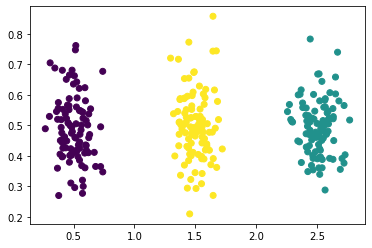

0 

In [6]:
import time
seed(0)
timeData = []
iterations = 100
nRange = [100]
particlesRange = [100] #500, 1000

for i, n in enumerate(nRange): #
    for j, particles in enumerate(particlesRange): 
        start = time.time()
        initTime, totalFitnessAvg, totalUpdateAvg, fitnessPerParticle, updatePerParticle = main_CPU(n = n, particles=particles, iterations=iterations)
        totalTime = time.time() - start
        timeData.append([particles, n, iterations, totalTime, initTime, totalFitnessAvg, 
                                                  totalUpdateAvg, fitnessPerParticle, updatePerParticle])
        print(i*len(nRange) + j, end = " ")

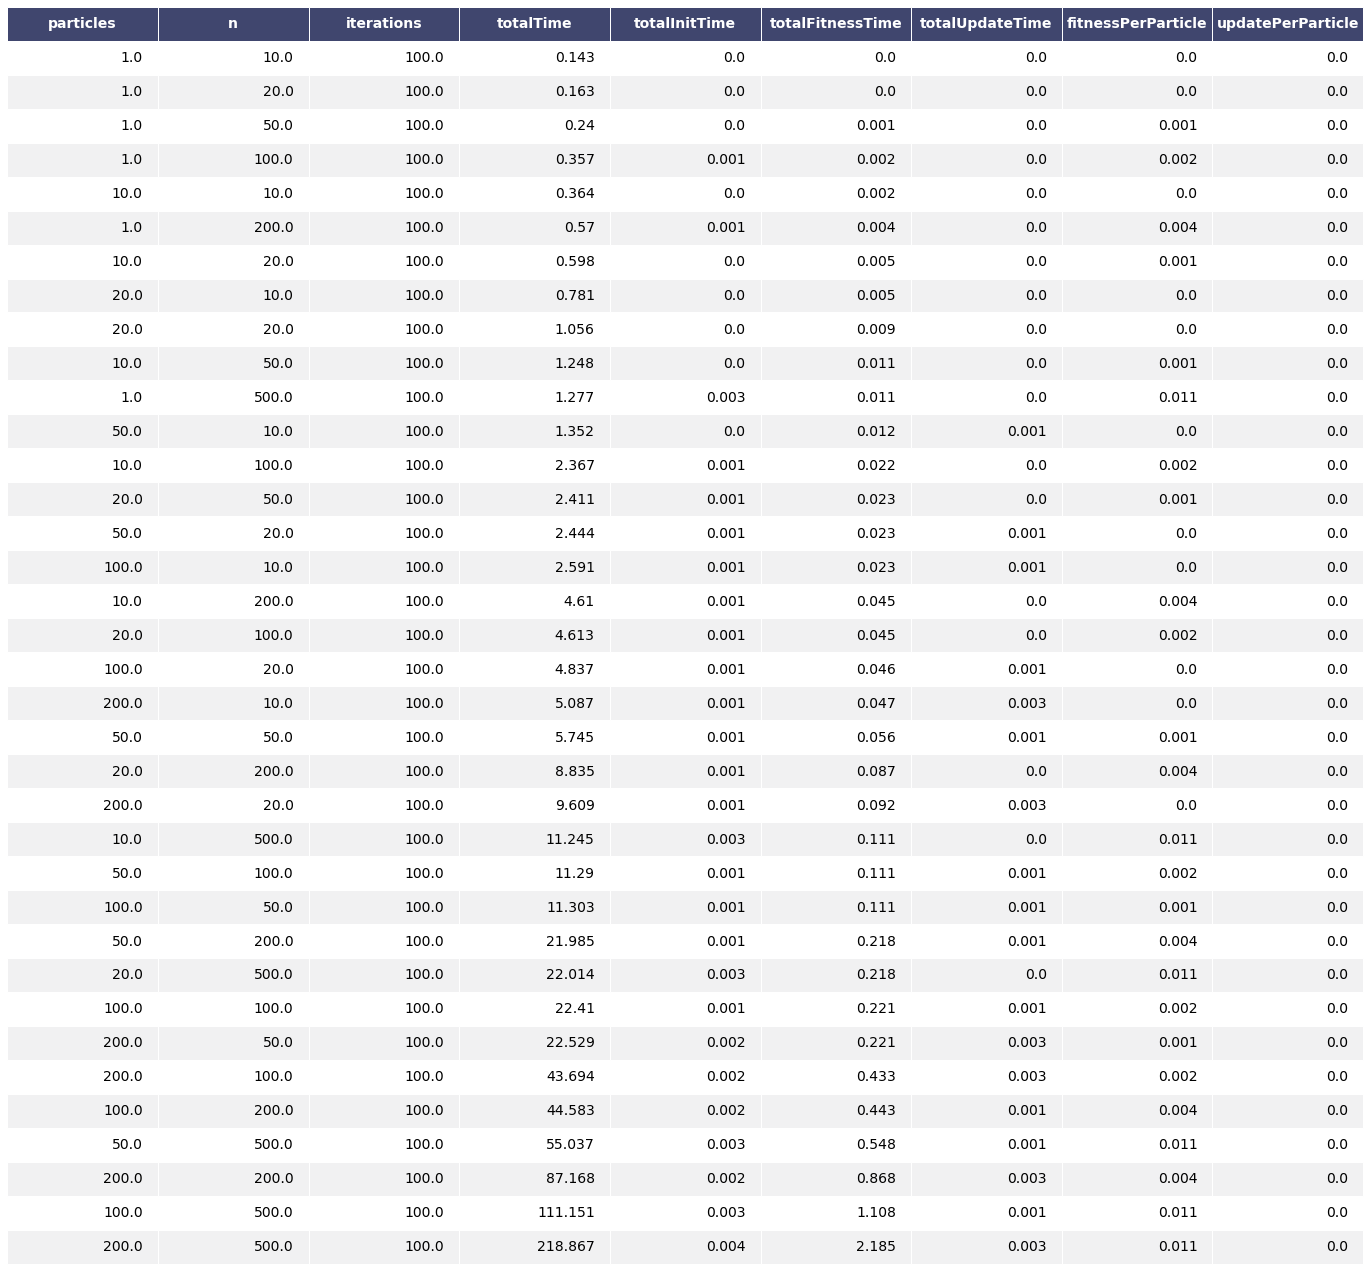

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#totalFitnessTime and totalUpdateTime are all average across iterations
timeProfiling = pd.DataFrame(timeData, columns = ["particles", "n", "iterations", "totalTime", 
                                        "totalInitTime", "totalFitnessTime", "totalUpdateTime", 
                                        "fitnessPerParticle", "updatePerParticle"])

timeProfiling = timeProfiling.round(3)
timeProfiling.sort_values(by=['totalTime'], inplace = True)

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(timeProfiling, header_columns=0, col_width=2.7)
fig.savefig("cpuProfile.pdf")
fig.savefig("cpuProfile.png")
timeProfiling.to_csv("cpuProfile.csv")
timeProfiling.to_excel("cpuProfile.xlsx")

# GPU code

In [ ]:
@cuda.jit
def fitness(particles_pos, data, num_particles, particle_fitness):
    index = cuda.grid(1)
    if index < num_particles:
        data_dim = data.shape[1]
        particle = particles_pos[index]
        sum_dists = 0
        for point in range(data.shape[0]):
            min_dist = -my_inf()
            for centroid in range(0, particle.shape[0], data_dim):
                dist = 0
                for k in range(data_dim):
                    dist += (data[point][k] - particle[centroid + k]) ** 2
                if(dist < min_dist):
                    min_dist = dist
            sum_dists += dist
        particle_fitness[index] = sum_dists/ data.shape[0]

In [ ]:
def update(particles_pos, particles_vel, particles_best_pos, global_best_pos, i, w, c1, c2):
    r1, r2 = random(), random()
    for d in range(len(particles_pos[i])):
        particles_vel[i][d] = w * particles_vel[i][d] + c1 * r1 * (particles_best_pos[i][d] - particles_pos[i][d]) + c2 * r2 * (global_best_pos[d] - particles_pos[i][d])
        particles_pos[i][d] += particles_vel[i][d]

In [ ]:
def main_GPU(
        data,
        n = 100,
        particles = 100,
        iterations = 100,
        c = 3,
        w = 0.99,
        c1 = 0.3,
        c2 = 0.3,
        blockdim = 16
    ):

    initStart = time.time()

    griddim = 1 + (particles - 1)//blockdim
    particles_pos, particles_vel = init_particles(particles, c, data)
    particles_best_pos = [i.copy() for i in particles_pos]
    particles_best_fit = [float('inf') for i in range(len(particles_pos))]
    particles_pos = numpy.array(particles_pos)
    
    initEnd = time.time()
    initTime = round(initEnd - initStart, 3)

    global_best_fit = float('inf')
    global_best_pos = None
    global_best_index = -1

    totalFitnessAvg = 0
    totalUpdateAvg = 0
    
    particles_pos_gpu = cuda.to_device(particles_pos)
    data_gpu = cuda.to_device(data)

    fitness_cpu = numpy.arange(particles).astype("float")
    fitness_gpu = cuda.to_device(fitness_cpu)
    
    for iter in range(iterations):
        totalFitnessStart = time.time()
        fitness[griddim, blockdim](particles_pos_gpu, data_gpu, particles, fitness_gpu)
        numba.cuda.synchronize()
        
        fitness_gpu.copy_to_host(fitness_cpu)
        
        data_gpu.copy_to_host(data)
        particles_pos_gpu.copy_to_host(particles_pos)

        for p in range(len(particles_pos)):
            fitness_p = fitness_cpu[p]
            if(fitness_p < particles_best_fit[p]):
                particles_best_fit[p] = fitness_p
                particles_best_pos[p] = particles_pos[p].copy()
            if(fitness_p < global_best_fit):
                global_best_fit = fitness_p
                global_best_pos = particles_pos[p].copy()
                global_best_index = p
        
        totalFitnessEnd = time.time() - totalFitnessStart
        totalFitnessAvg += round(totalFitnessEnd, 3)

        totalUpdateStart = time.time()
        for p in range(len(particles_pos)):
            update(particles_pos, particles_vel, particles_best_pos, global_best_pos, p, w, c1, c2)

        particles_pos_gpu = cuda.to_device(particles_pos)    
        totalUpdateEnd = time.time() - totalUpdateStart
        totalUpdateAvg += round(totalUpdateEnd, 3)
    
    totalFitnessAvg = round(totalFitnessAvg/iterations, 3)
    totalUpdateAvg = round(totalUpdateAvg/iterations, 3)
    fitnessPerParticle = round(totalFitnessAvg/particles, 3)
    updatePerParticle = round(totalUpdateAvg/particles, 3)

    for i in range(global_best_index, global_best_index + 1):
        l = []
        for point in data:
            min_dist = float('inf')
            min_value = None
            for centroid in range(0, len(particles_best_pos[i]), len(data[0])):
                dist = 0
                for k in range(len(data[0])):
                    dist += (point[k] - particles_best_pos[i][centroid + k]) ** 2
                if dist < min_dist:
                    min_dist = dist
                    min_value = centroid // len(data[0])
            l.append(min_value)
        
        plt.scatter(*zip(*data), c = l)
        plt.show()
    return (initTime, totalFitnessAvg, totalUpdateAvg, fitnessPerParticle, updatePerParticle)

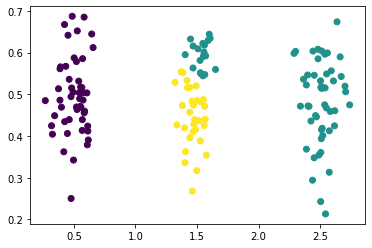

0 

In [ ]:
import time
seed(0.03)
timeData = []
iterations = 100
nRange = [50]
particlesRange = [1000]

c = 3
w = 0.99
c1 = 0.15
c2 = 0.2

#seed(time.time())


for i, n in enumerate(nRange): #
    for j, particles in enumerate(particlesRange): 
        start = time.time()
        data = numpy.array(random_data(n, c))
        initTime, totalFitnessAvg, totalUpdateAvg, fitnessPerParticle, updatePerParticle = main_GPU(data, n = n, particles=particles, iterations=iterations, c = c, w = w, c1 = c1, c2 = c2)
        totalTime = time.time() - start
        timeData.append([particles, n, iterations, totalTime, initTime, totalFitnessAvg, 
                                                  totalUpdateAvg, fitnessPerParticle, updatePerParticle])
        print(i*len(nRange) + j, end = " ")

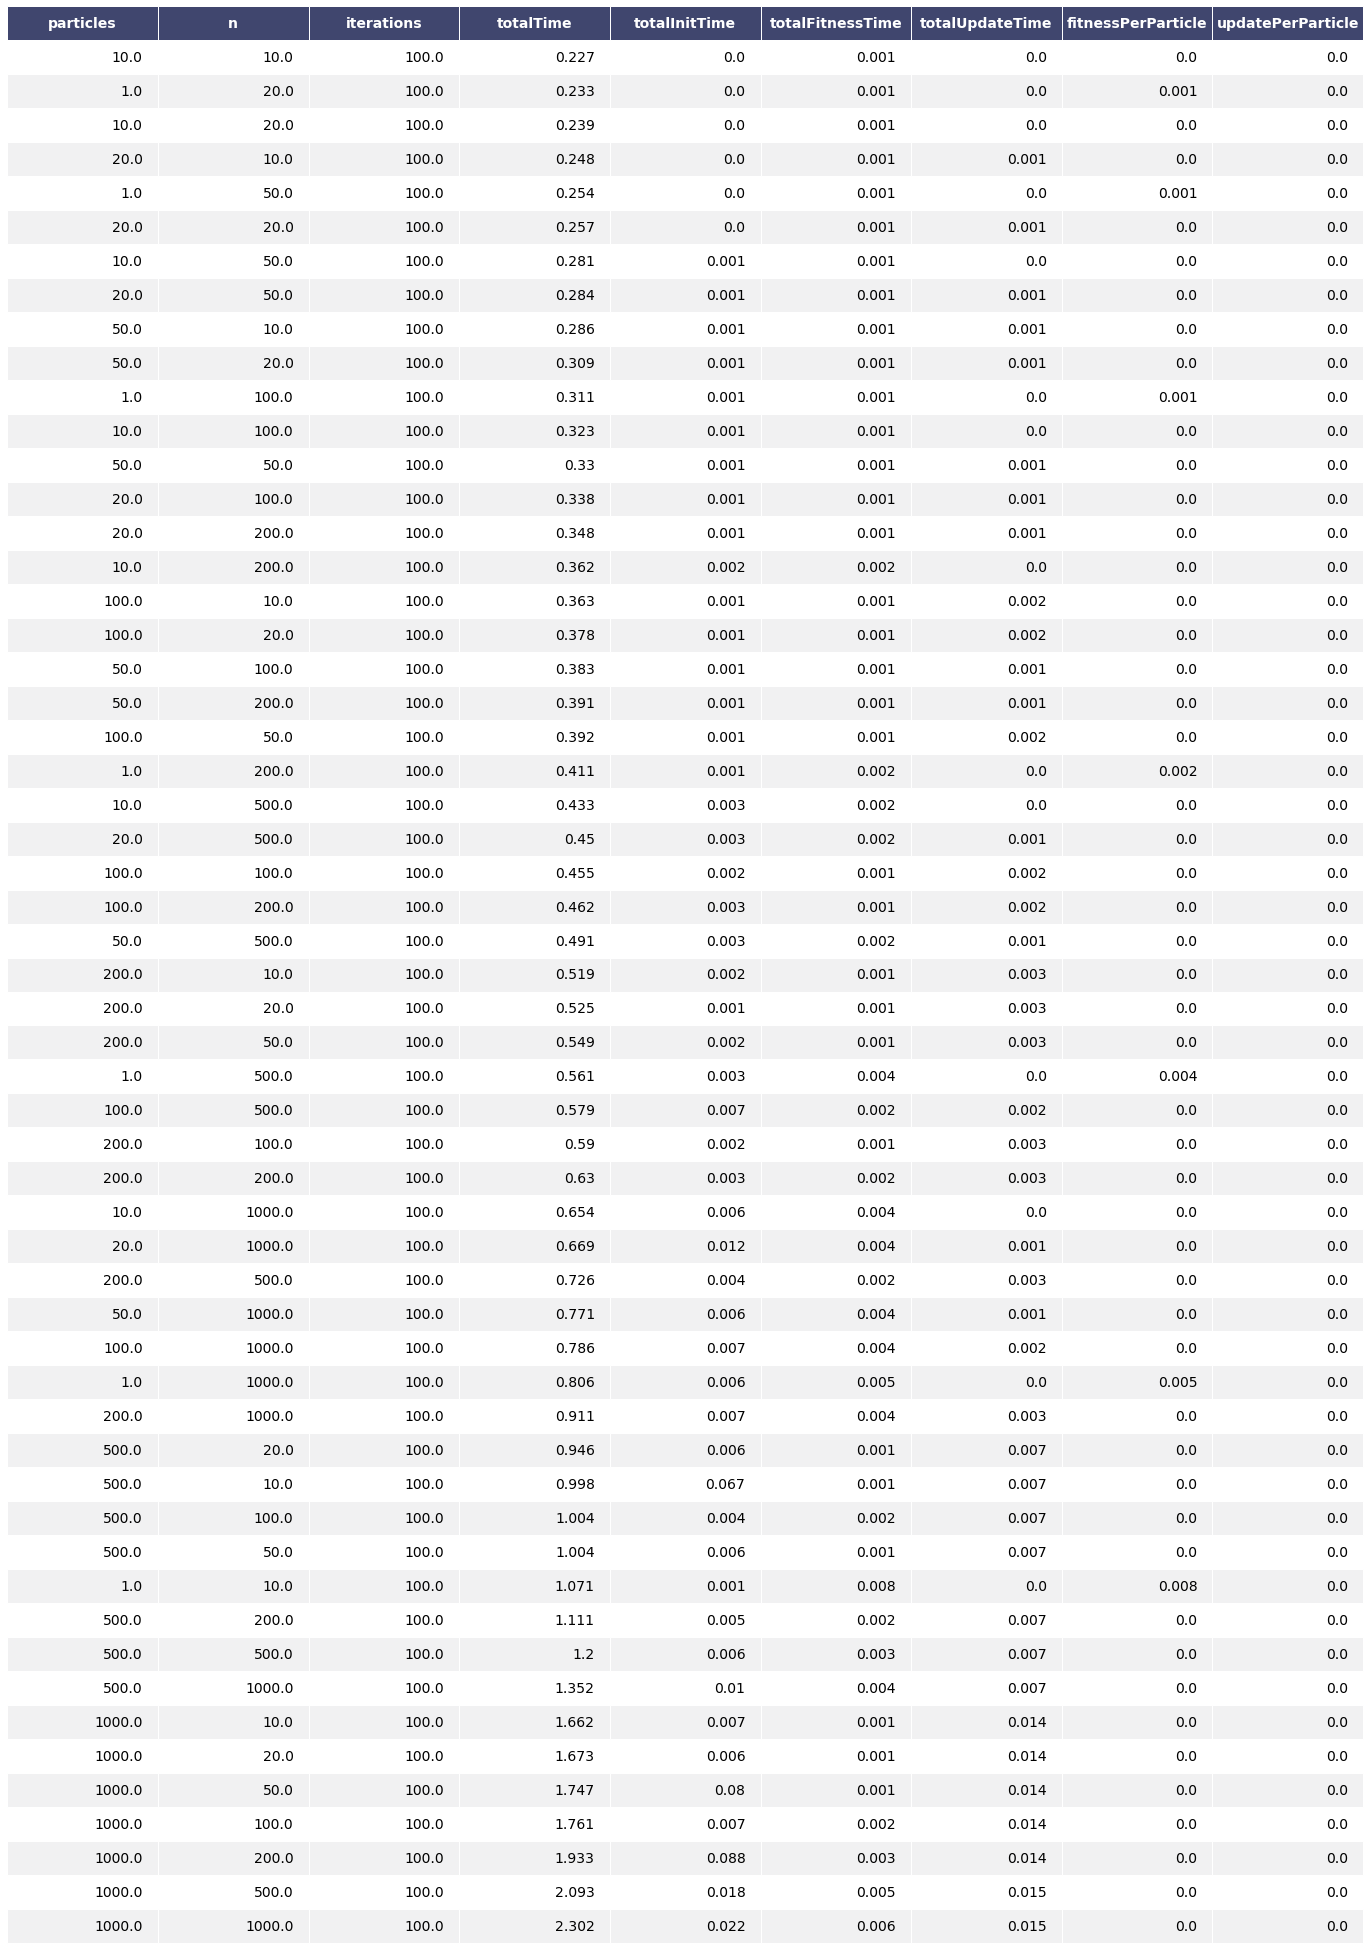

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#totalFitnessTime and totalUpdateTime are all average across iterations
timeProfiling = pd.DataFrame(timeData, columns = ["particles", "n", "iterations", "totalTime", 
                                        "totalInitTime", "totalFitnessTime", "totalUpdateTime", 
                                        "fitnessPerParticle", "updatePerParticle"])

timeProfiling = timeProfiling.round(3)
timeProfiling.sort_values(by=['totalTime'], inplace = True)

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(timeProfiling, header_columns=0, col_width=2.7)
fig.savefig("gpuProfile.pdf")
fig.savefig("gpuProfile.png")
timeProfiling.to_csv("gpuProfile.csv")
timeProfiling.to_excel("gpuProfile.xlsx")